In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_excel("data.xlsx")
df.drop(["Date", "Time"], inplace=True, axis=1)
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


In [3]:
def missvalue_pre(data):
    feature_columns = data.columns.tolist()
    sample_num = data.shape[0]
    missvalue = []
    for col in feature_columns:
        sum_col = (data[col] <  0).sum()
        missvalue.append(sum_col / sample_num)
    miss_value = pd.Series(missvalue, index=feature_columns)
    print(miss_value)

missvalue_pre(df)

CO(GT)           0.189639
PT08.S1(CO)      0.043790
NMHC(GT)         0.900335
C6H6(GT)         0.043790
PT08.S2(NMHC)    0.043790
NOx(GT)          0.188203
PT08.S3(NOx)     0.043790
NO2(GT)          0.188562
PT08.S4(NO2)     0.043790
PT08.S5(O3)      0.043790
T                0.045465
RH               0.043790
AH               0.043790
dtype: float64


###### 可以看到，不同列中缺失值占比不同

In [4]:
# seperately_cols = ["CO(GT)", "NMHC(GT)", "NOx(GT)", ""]
fill_cols = ["PT08.S1(CO)", "C6H6(GT)", "PT08.S2(NMHC)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "RH", "AH"]

def data_process(df):
    for col in fill_cols:
        fill_value = df.loc[df[col] >= 0, col].mean()
        df.loc[df[col] < 0, col] = fill_value
    df.loc[df["NMHC(GT)"] == -200, "NMHC(GT)"] = 0
    return df

df = data_process(df)

In [5]:
missvalue_pre(df)

CO(GT)           0.189639
PT08.S1(CO)      0.000000
NMHC(GT)         0.000000
C6H6(GT)         0.000000
PT08.S2(NMHC)    0.000000
NOx(GT)          0.188203
PT08.S3(NOx)     0.000000
NO2(GT)          0.188562
PT08.S4(NO2)     0.000000
PT08.S5(O3)      0.000000
T                0.000000
RH               0.000000
AH               0.000000
dtype: float64


##### 为两个任务创建数据集

In [6]:
df_preCO_train = df[df["CO(GT)"] != -200]
df_preNOx_train = df[df["NOx(GT)"] != - 200]
df_preCO_test = df[df["CO(GT)"] == -200].drop(["CO(GT)"], axis=1)
df_preNOx_test = df[df["NOx(GT)"] == -200].drop(["NOx(GT)"], axis=1)

In [7]:
df_preCO_train.shape, df_preNOx_train.shape, df_preCO_test.shape, df_preNOx_test.shape

((6773, 13), (6785, 13), (1585, 12), (1573, 12))

In [8]:
missvalue_pre(df_preCO_train), missvalue_pre(df_preNOx_train)

CO(GT)           0.000000
PT08.S1(CO)      0.000000
NMHC(GT)         0.000000
C6H6(GT)         0.000000
PT08.S2(NMHC)    0.000000
NOx(GT)          0.056696
PT08.S3(NOx)     0.000000
NO2(GT)          0.057139
PT08.S4(NO2)     0.000000
PT08.S5(O3)      0.000000
T                0.000000
RH               0.000000
AH               0.000000
dtype: float64
CO(GT)           0.058364
PT08.S1(CO)      0.000000
NMHC(GT)         0.000000
C6H6(GT)         0.000000
PT08.S2(NMHC)    0.000000
NOx(GT)          0.000000
PT08.S3(NOx)     0.000000
NO2(GT)          0.000442
PT08.S4(NO2)     0.000000
PT08.S5(O3)      0.000000
T                0.000000
RH               0.000000
AH               0.000000
dtype: float64


(None, None)

###### 首先继续对两个数据集做填充

In [9]:
fill_cols_CO = ["NOx(GT)", "NO2(GT)"]
fill_cols_NOx = ["CO(GT)", "NO2(GT)"]
for col in fill_cols_CO:
    fill_value = df_preCO_train.loc[df_preCO_train[col] >= 0, col].mean()
    df_preCO_train.loc[df_preCO_train[col] < 0, col] = fill_value
for col in fill_cols_NOx:
    fill_value = df_preNOx_train.loc[df_preNOx_train[col] >= 0, col].mean()
    df_preNOx_train.loc[df_preNOx_train[col] < 0, col] = fill_value

##### 现在数据集填充完毕

###### 处理分类预测数据集

In [10]:
threshold = df_preCO_train["CO(GT)"].mean()
threshold

2.1469511294847186

In [11]:
df_preCO_train["target"] = np.where(df_preCO_train["CO(GT)"] > threshold, 1, 0)

C:\Users\learn\AppData\Local\Temp\ipykernel_9988\3021052247.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preCO_train["target"] = np.where(df_preCO_train["CO(GT)"] > threshold, 1, 0)


In [12]:
df_preCO_train.drop(["CO(GT)"], axis=1, inplace=True)

C:\Users\learn\AppData\Local\Temp\ipykernel_9988\1822431144.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preCO_train.drop(["CO(GT)"], axis=1, inplace=True)


In [13]:
# df_preCO_train.rename(columns={"target":"CO(GT)"}, inplace=True)
df_preNOx_train.rename(columns={"NOx(GT)":"target"}, inplace=True)

C:\Users\learn\AppData\Local\Temp\ipykernel_9988\738125502.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preNOx_train.rename(columns={"NOx(GT)":"target"}, inplace=True)


###### 处理回归预测数据集

### 开始找到异常点并进行替代

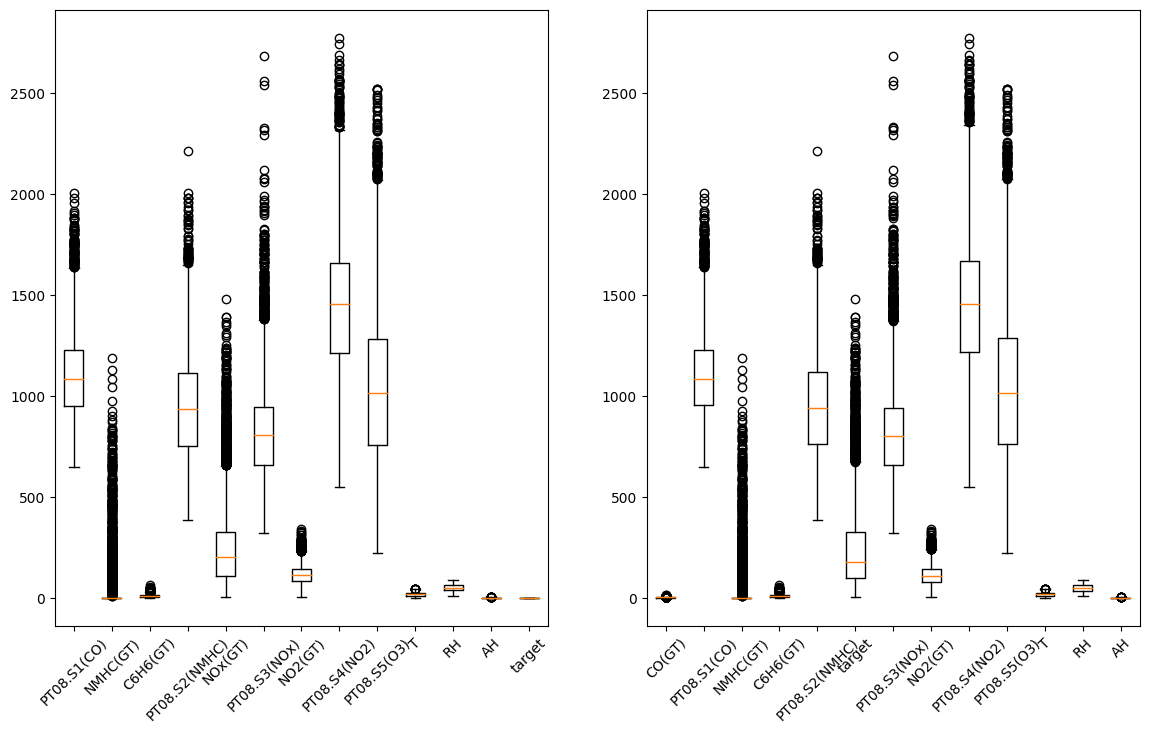

In [14]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.boxplot(df_preCO_train.values, labels=df_preCO_train.columns)
plt.xticks(fontsize=10, rotation=45)
plt.subplot(1, 2, 2)
plt.boxplot(df_preNOx_train.values, labels=df_preNOx_train.columns)
plt.xticks(fontsize=10, rotation=45)
plt.show()

In [15]:
# def findoutliners(X, sigma=3):
#     outliners = []
#     for col in X.columns:
#         mean = np.mean(X[col])
#         std = np.std(X[col])
#         for i, val in enumerate(X[col]):
#             if np.abs((val - mean) / std) > sigma:
#                 outliners.append((col, i, val))
#     return outliners

# outliners = findoutliners(df_preCO_train)
# print(outliners)
# for col, index, val in outliners:
#     if col != "CO(GT)":
#         mean = np.mean(df_preCO_train[col])
#         df_preCO_train.loc[index, col] = mean
# print("----------------------")
# outliners = findoutliners(df_preNOx_train)
# print(outliners)
# for col, index, val in outliners:
#     if col != "NOx(GT)":
#         mean = np.mean(df_preNOx_train[col])
#         df_preNOx_train.loc[index, col] = mean


In [16]:
# plt.figure(figsize=(14, 8))
# plt.subplot(1, 2, 1)
# plt.boxplot(df_preCO_train, labels=df_preCO_train.columns)
# plt.xticks(fontsize=10, rotation=45)
# plt.show()

In [17]:
# plt.figure(figsize=(14, 8))
# plt.subplot(1, 2, 1)
# plt.boxplot(df_preCO_train.values, labels=df_preCO_train.columns)
# plt.xticks(fontsize=10, rotation=45)
# plt.subplot(1, 2, 2)
# plt.boxplot(df_preNOx_train.values, labels=df_preNOx_train.columns)
# plt.xticks(fontsize=10, rotation=45)
# plt.show()

#### 接下来需要对训练集和测试集做一致性处理

In [18]:
def fill_value(df, df_test=None):
    y = df["target"]
    X = df.drop(["target"], axis=1)
    feature_columns = X.columns
    if not df_test.empty:
        for col in feature_columns:
            df_test.loc[df_test[col] < 0, col] = df[col].mean()

fill_value(df_preCO_train, df_preCO_test)
fill_value(df_preNOx_train, df_preNOx_test)

In [19]:
from sklearn.preprocessing import MinMaxScaler

def minmax(df, df_test=None):
    y = df["target"]
    X = df.drop(["target"], axis=1)
    feature_columns = X.columns
    minmaxscaler = MinMaxScaler()
    X = minmaxscaler.fit_transform(X)
    data = pd.DataFrame(X, columns=feature_columns)
    if not df_test.empty:
        df_test = minmaxscaler.transform(df_test)
        data_test = pd.DataFrame(df_test, columns=feature_columns)
    y = y.reset_index(drop=True)
    data = pd.concat([data, y], axis=1)
    return data, data_test

data_preNOX, data_preNOX_test = minmax(df_preNOx_train, df_preNOx_test)
data_preCO, data_preCO_test = minmax(df_preCO_train, df_preCO_test)

In [20]:
data_preNOX.shape, data_preCO.shape

((6785, 13), (6773, 13))

In [21]:
import seaborn as sns

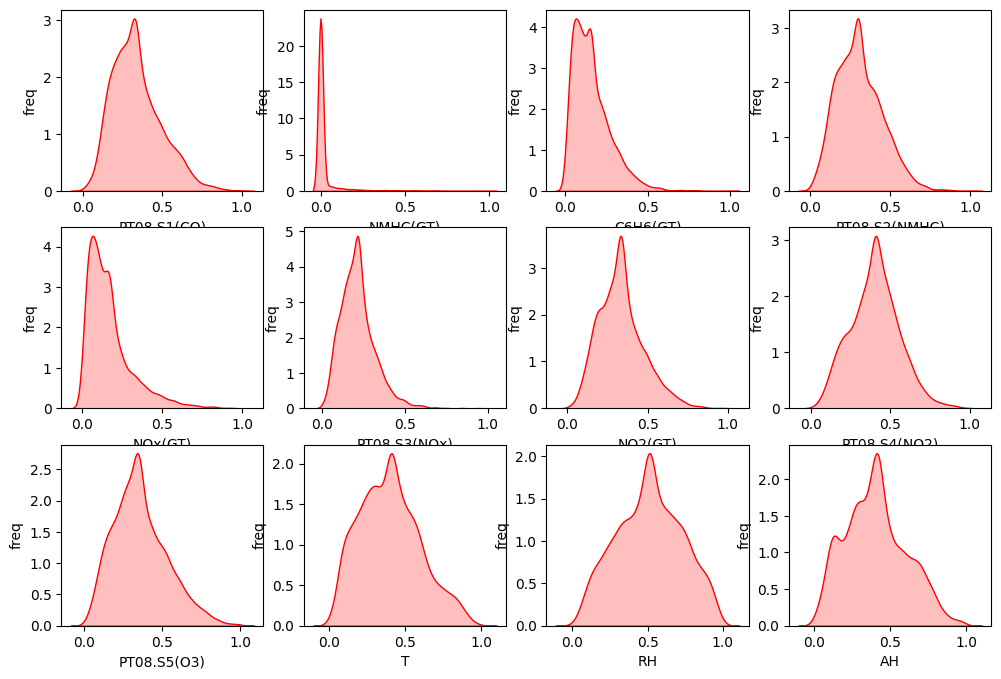

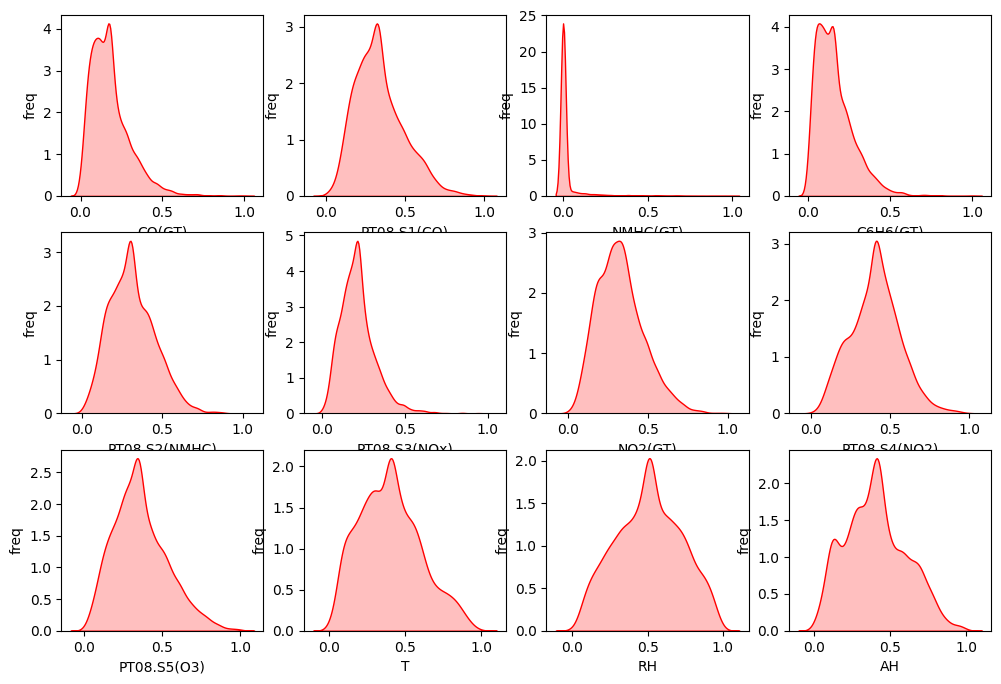

In [22]:
def plot_kde(data):
    rows = 3
    cols = 4
    plt.figure(figsize=(12, 8))
    for i, col in enumerate(data.columns.tolist()):
        if col != "target":
            ax = plt.subplot(rows, cols, i + 1)
            ax = sns.kdeplot(data[col], color='r', fill=True)
            ax.set_xlabel(col)
            ax.set_ylabel("freq")
    plt.show()
    
plot_kde(data_preCO)
plot_kde(data_preNOX)

##### 线性回归分析

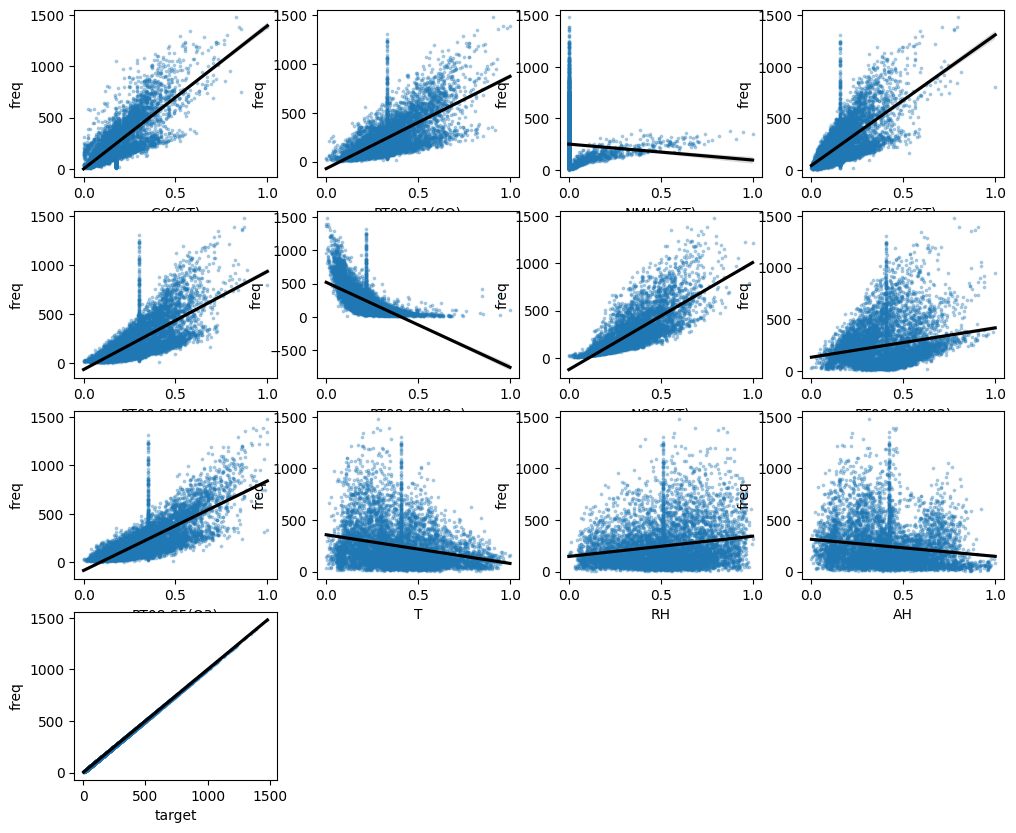

In [23]:
def plot_reg(data, target):
    rows = 4
    cols = 4
    plt.figure(figsize=(12, 10))
    for i, col in enumerate(data.columns.tolist()):
        ax = plt.subplot(rows, cols, i + 1)
        ax = sns.regplot(x=col, y=target, data=data, ax=ax, scatter_kws={'marker':'.', 's':3, 'alpha':0.3}, line_kws={'color':'k'})
        ax.set_xlabel(col)
        ax.set_ylabel("freq")
    plt.show()

plot_reg(data_preNOX, "target")

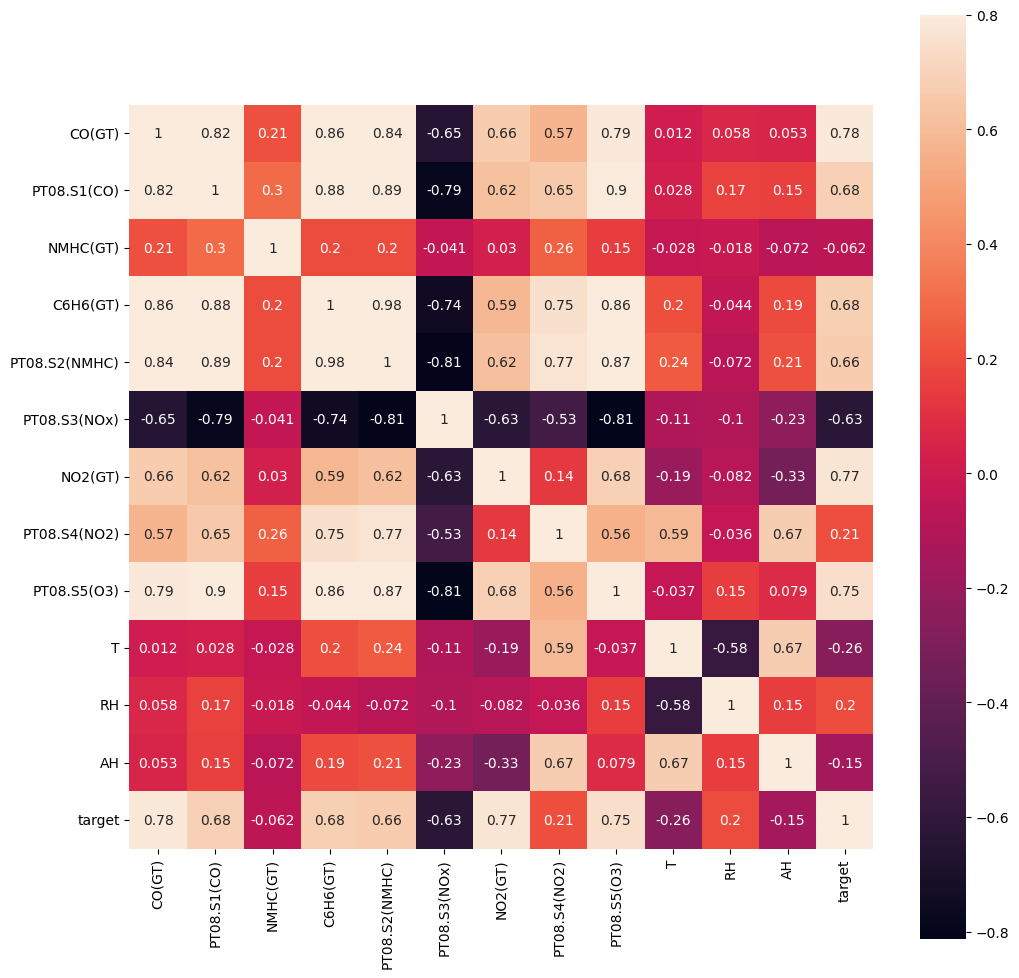

In [24]:
plt.figure(figsize=(12, 12))
sns.heatmap(data_preNOX.corr(), vmax=.8, square=True, annot=True)
plt.show()

In [25]:
def nlarge_features(df, target):
    k = 6
    cols = df.corr().nlargest(k, target)[target].index
    print(cols.values[1:])

nlarge_features(data_preNOX, 'target')

['CO(GT)' 'NO2(GT)' 'PT08.S5(O3)' 'PT08.S1(CO)' 'C6H6(GT)']


###### 可以用regplot查看连续型与连续型，协方差矩阵查看回归任务的关系； 用小提琴图查看回归问题之间的关系

In [26]:
data_preNOX.shape, data_preCO.shape

((6785, 13), (6773, 13))

In [27]:
data_preCO.head()

,PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,target
0,0.523888,0.126156,0.184294,0.360514,0.108622,0.311024,0.328694,0.513040,0.454654,0.304153,0.509628,0.287117,1
1,0.474090,0.094197,0.145214,0.310850,0.065852,0.360796,0.266509,0.453125,0.326382,0.297419,0.494544,0.270951,0
2,0.554759,0.074012,0.138933,0.302367,0.084861,0.346500,0.331655,0.451214,0.370588,0.265993,0.575096,0.283352,1
3,0.535281,0.067283,0.142566,0.307292,0.112695,0.326168,0.355345,0.464366,0.426741,0.245791,0.652439,0.301626,1
4,0.459390,0.042893,0.099931,0.245588,0.084861,0.374034,0.337578,0.422212,0.386228,0.249158,0.646983,0.302669,0


In [29]:
# def plot_violin(data, target):
#     features = data.columns.tolist()
#     rows, cols = 4, 4
#     plt.figure(figsize=(18, 14))
#     for i, col in enumerate(features):
#         ax = plt.subplot(rows, cols, i + 1)
#         sns.violinplot(x=data[col], y=data[target], ax=ax)
#         ax.set_xlabel(col)
#         ax.set_ylabel(target)
#     plt.tight_layout()
#     plt.show()

# plot_violin(data_preCO, "target")

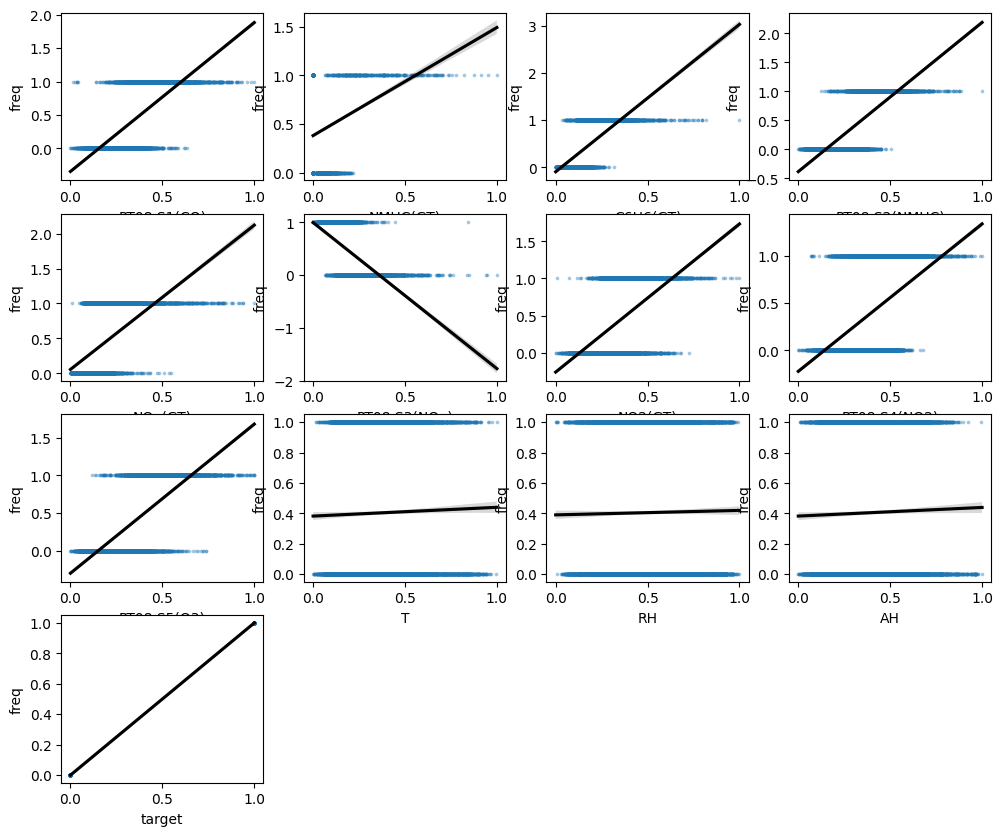

In [30]:
plot_reg(data_preCO, "target")

##### 分别保存处理后的数据集